# Neural Network: XY -> Grayscale

We are going to be creating what is sometimes known as a [__Compositional Pattern-Producing Network__](https://en.wikipedia.org/wiki/Compositional_pattern-producing_network), or a CPPN. [David Ha](https://twitter.com/hardmaru) wrote a [few](https://blog.otoro.net/2016/03/25/generating-abstract-patterns-with-tensorflow/) [blog](https://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) [posts](https://blog.otoro.net/2016/04/06/the-frog-of-cifar-10/) some years ago which really explore this topic and produce some really interesting images. 

Research in CPPN's also fed into the work [Alexander Mordvintsev](https://znah.net/) et al. produced on [Differential Image Parameterizations](https://distill.pub/2018/differentiable-parameterizations/) and the [Lucid](https://github.com/tensorflow/lucid) framework for producing really interesting visualisations based on activations within more complex neural networks.

There is also the [CPPN Playground](https://silky.github.io/cppn-playground/) which is very nice!

---

We are going to train a neural network to map a 2D coordinate as input to a single number as output. The 2D coordinate will represent a pixel location in an image, and the output number will be the grayscale value of that pixel. Essentially we are trying to _learn the function_:

$$ c = f(x, y) $$

where $c$ is the grayscale _colour_ at the given coordinates $x, y$.

Here is what we are going to do but in a 2x2 image. Note that each pixel coordinate maps to a single value:

![Image as Dataset](../images/image-as-dataset.png)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt

## Dataset

We will use Scikit-Image to give us an image. SciKit [has a bunch of images](https://scikit-image.org/docs/dev/api/skimage.data.html) so if you ever need a quick image to test with that's a great resource (this is great as you don't need to worry about image formats like PNG or JPG and you just get it as a NumPy array).

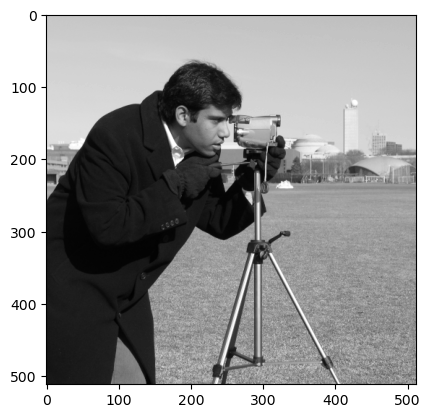

In [3]:
img = skimage.data.camera()
smaller_img = resize(img, (64, 64)) # Resize it just to make things quicker
plt.imshow(img, cmap='gray')

As stated at the top, that single image actually represents an entire dataset: each pixel is a __datapoint__, and the image is the __dataset__.

So we need to split the image up so that out inputs are the XY pixel coordinates and the outputs are the pixel values.

Computation in machine learning is generally best when scaled to be in the range [-1, 1] - you will see this a lot. It just makes floating point computation a lot more efficient and helps prevent values exploding into gigantic numbers (which will happen any way). So we also need to remap our pixel coordinate to fall within the range [-1, 1]:

![Remap Coords](../images/remap-coords.png)

We will use `tf.linspace()` to do get a smooth interpolation from [-1, 1], with the number of steps equal to the number of pixels. We will also `tf.meshgrid()` to turn these two 1D arrays into a grid of 2D coordinates. And then reshape the outcome of this into a list of coordinates which will become the input to our model. This all get wraps up into a function called `get_mgrid()` below.

If `get_mgrid()` is confusing I _really_ recommend dissecting the function and looking at it _line by line_. See what `linspace` does, and then see what `meshgrid` does, then see what `stack` does... and so on. It's simpler than you might think.

In [6]:
def get_mgrid(sidelen):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    width = np.linspace(-1, 1, sidelen)
    height = np.linspace(-1, 1, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)
    mgrid = np.reshape(mgrid, [-1, 2])
    return mgrid

Now we can build our dataset!

We gain our input coords using the function above. And the outputs `y` are just the pixel values, so we simply reshape our image into a long 1D array.

In `tf.reshape` below, the argument `[-1, 1]` simply means we want the second dimension to be 1, and then the `-1` tells Tensorflow to infer the other dimension based on the data. So it just flattens the data.

In [7]:
image_side_length = smaller_img.shape[0]
X = get_mgrid(image_side_length)      # Inputs
y = tf.reshape(smaller_img, [-1, 1])  # Outpus

print(X.shape)
print(y.shape)

(4096, 2)
(4096, 1)


## Model

We can now build our model. We will use the `Sequential` model builder from Keras to help us do that. It's just a convenient way of stacking layers up... sequentially.

Our NN will take 2 inputs, the first hidden layer has 16 nodes, the next has 32, and then the output is a single scalar. The activation on the last layer is the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function which will squash all values to a number between [0, 1]. This is just convenient for us when it comes to rescaling those number into [0, 255] to create an image.

Lets graph the Sigmoid function just cos we can :)

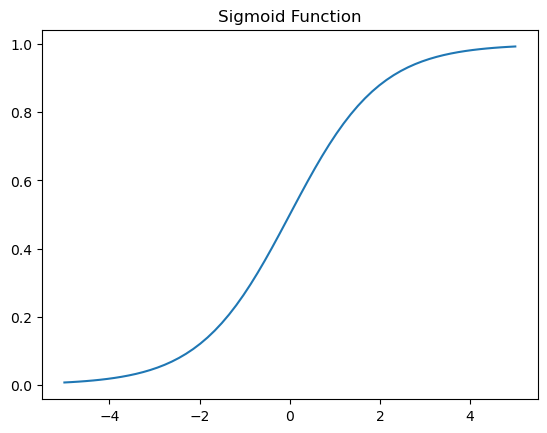

In [9]:
_x = np.linspace(-5, 5, 64)
_y = tf.sigmoid(_x)
plt.title('Sigmoid Function')
plt.plot(_x, _y)

This is what our net looks like:

![Network](../images/nn.png)

It is often at this point that you ask _how do you know how many hidden layers to use?_ or _how do you know how many neurons to use?_ or _how do you know which activation function to use?_.

The short answer is I don't know, and I honestly don't think anyone _really_ knows. There is just a certain amount of intuition based on the size of your dataset and what you're trying to acheive. In our case our dataset is tiny so our model can be small. The main consideration in this case is the use of the Sigmoid on the last layer. [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) for the other layers is just pretty much standard at this point as it's efficient and simple. BUT these are things for you to play with shortly...

For now, after defining our sequential model, we `compile` it. This is a feature of Keras which gets our model ready for training. We _compile_ the model with the loss function and the optimizer. We'll use the humble Mean Squared Error and Stochastic Gradient Descent in this case.

In [10]:
# Our model!
model = Sequential([
    Dense(16, input_dim=2, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='mse', optimizer='sgd')

# Training

Finally we can train. Keras makes this simple, we just call `model.fit()` and pass in the data, number of epochs we would like to train with and the batch size.

In [11]:
model.fit(X, y, epochs=8, batch_size=1)

Epoch 1/8


2023-01-25 20:23:28.359895: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-25 20:23:28.478549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4096/4096 [==============================] - 15s 4ms/step - loss: 0.0478
Epoch 2/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0314
Epoch 3/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0256
Epoch 4/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0225
Epoch 5/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0205
Epoch 6/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0190
Epoch 7/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0178
Epoch 8/8
4096/4096 [==============================] - 14s 3ms/step - loss: 0.0170


# Using the Model

Great, we now have a trained model! So let's use it. We can give the model the coordinates we used to train with and see what kind of image it produces.. or if it creates an image at all?

> Bare in mind this is all generally considered "bad practice" in machine learning. We are using the training data to test the model.. Normally we want a model to _generalise_ so that we can use __new__ data on the model to prove that the model has learnt how to deal with that _type_ of data, rather than only the data we had in the first place.

> However this is a special case. We are literally _trying to overfit_. We are training a model to learn the function which will _recreate our dataset_, pixel-for-pixel, that is what we want.

In [12]:
# Our traning data is stored in 'X', so lets pass that
# into our trained model and see what it produces.
prediction = model.predict(X)

# Our 'y' training data was a 1D array remember, so it 
# makes sense that the output of our model is the same.
print(prediction.shape)

 77/128 [=================>............] - ETA: 0s

2023-01-25 20:25:40.603394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 0s 2ms/step
(4096, 1)


Lets look at the output of our model a little bit...

In [13]:
# Look at the first 10 values of the output.
print(prediction[:10])

[[0.97129077]
 [0.96878046]
 [0.9660582 ]
 [0.96310776]
 [0.95991147]
 [0.95645076]
 [0.95270604]
 [0.9486565 ]
 [0.9442807 ]
 [0.93955564]]


We used the Sigmoid activation on the output layer to keep the values between [0, 1]. But to be sure we can check the minimum and maximum values.

In [14]:
min_val = prediction.min()
max_val = prediction.max()

print(min_val, max_val)

0.072983555 0.97129077


Excellent. Finally, before we can view the image we need to do some more data reshaping. I'm going wrap this little routine into a function which can call again later on.

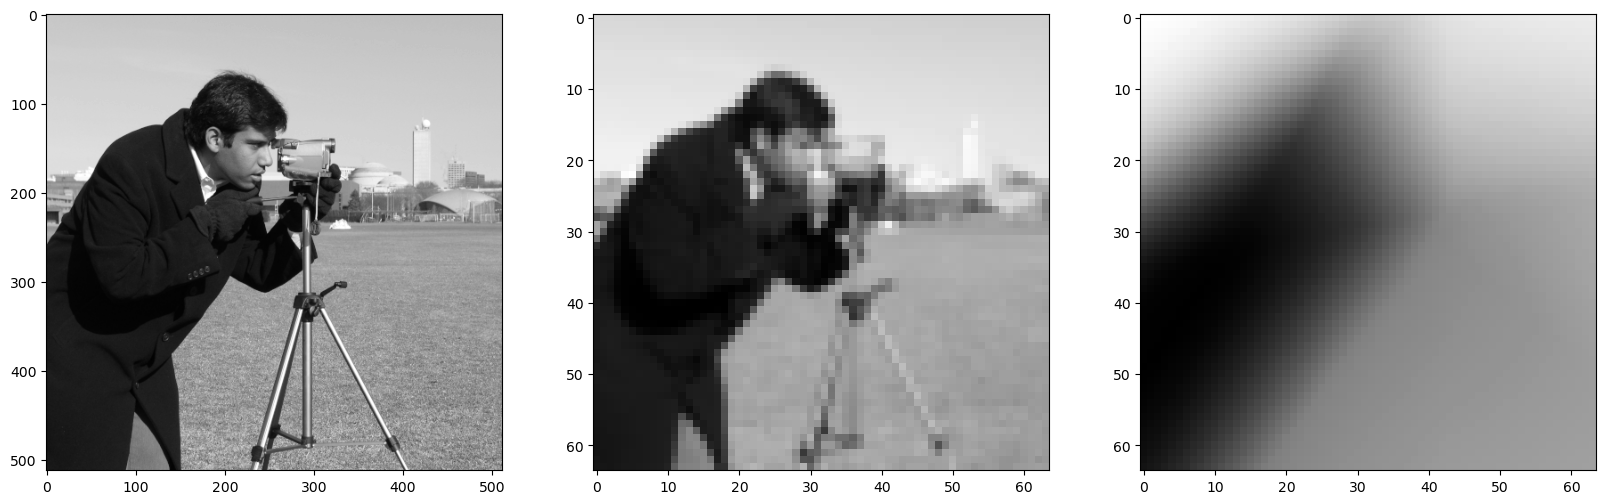

In [15]:
def view_output(prediction, image_shape=(64,64)):
    # Reshape it from 1D to 2D
    reconstructed_img = tf.reshape(prediction, image_shape)
    
    # Scale the values from [0,1] to [0, 255]
    reconstructed_img *= 255
    
    # Convert the tensor into a numpy array, and cast the type into a uint8.
    reconstructed_img = reconstructed_img.numpy().astype(np.uint8)
    
    # Look at our creation next to the original!
    fig, axes_array = plt.subplots(1,3, figsize=(20,10))
    axes_array[0].imshow(img, cmap='gray')
    axes_array[1].imshow(smaller_img, cmap='gray')
    axes_array[2].imshow(reconstructed_img, cmap='gray')
    plt.show()
    
view_output(prediction)

I don't think that's too bad! It's not exactly groundbreaking, but this will never cease to blow my mind. We have trained a model on a bag of coordinates and a corresponding value. The trained model can now recreate the image simply by giving it the coordinates.

OK fine it's not re-creating the image, there are far better compression algorithms out there which can recreate an image with a lot less.. But still! We did it, it's ours, and I love it.

## Improving Our Model

Although our blurry image is still cool and exciting... we can do better than that. The first thing I'm going to change is the optimizer, and I'm going to use Adaptive Moment Estimation, or [ADAM](https://www.youtube.com/watch?v=Syom0iwanHo). The optimizer determines _how_ and at what _rate_ the weights of the network are updated. So having an efficient optimizer can greatly improve how a model learns.

Have a look at the loss compared to the training earlier with Stochastic Gradient Descent, you might notice that from as early as the first epoch we have significantly lower loss (low loss is good).

Lets also train for twice as long.

In [16]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=16, batch_size=1)

Epoch 1/16
  22/4096 [..............................] - ETA: 19s - loss: 0.0174    

2023-01-25 20:25:52.975147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4096/4096 [==============================] - 18s 4ms/step - loss: 0.0164
Epoch 2/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0148
Epoch 3/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0139
Epoch 4/16
4096/4096 [==============================] - 16s 4ms/step - loss: 0.0124
Epoch 5/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0113
Epoch 6/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0106
Epoch 7/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0099
Epoch 8/16
4096/4096 [==============================] - 18s 4ms/step - loss: 0.0094
Epoch 9/16
4096/4096 [==============================] - 18s 4ms/step - loss: 0.0091
Epoch 10/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0089
Epoch 11/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0086
Epoch 12/16
4096/4096 [==============================] - 17s 4ms/step - loss: 0.0084


 75/128 [================>.............] - ETA: 0s

2023-01-25 20:30:41.032424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 0s 2ms/step


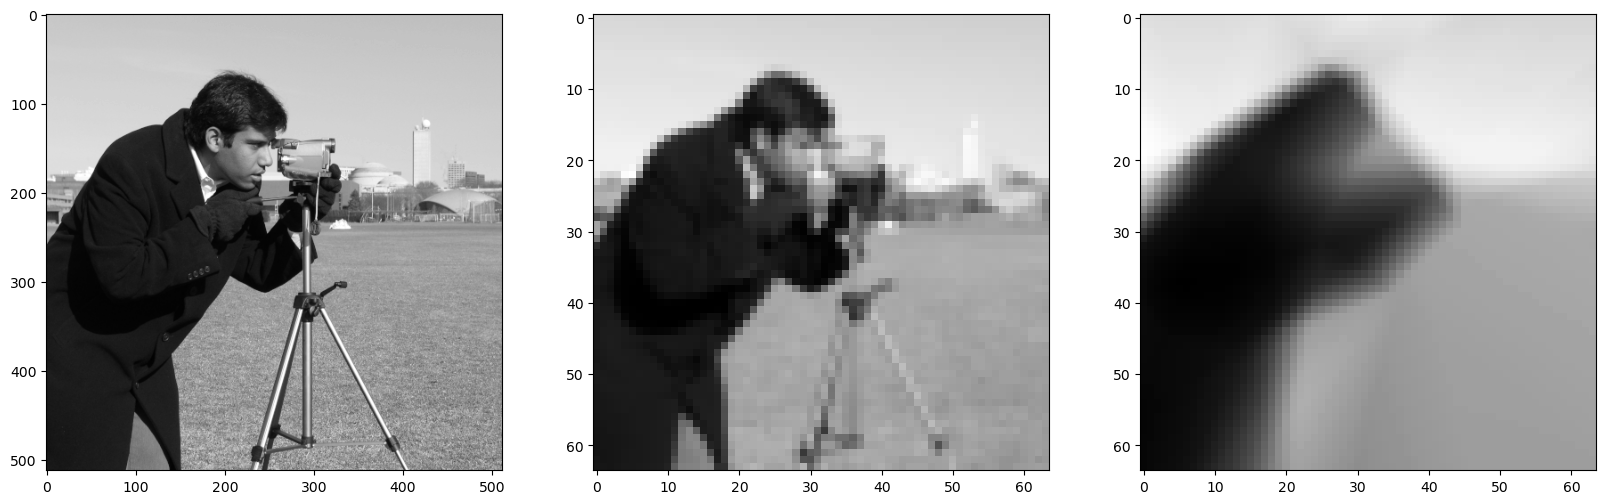

In [17]:
new_prediction = model.predict(X)
view_output(new_prediction)

That looks a bit better!

## Doing more with our model

I may have said all that about overfitting and going against what ML normally aims for. But acutally, we _do_ in fact have a general function now. The aim was to reproduce the original image from the original pixel coordinates.. but who said we need to give it the original pixel coordinates?

The first thing we can do is increase the resolution of our output image. To do this we just need to give it higher resolution input coordinates.

Our training coordinates use `linspace` to go from [-1, 1] in 64 steps in width and height. This is simply because we had 64 pixels in width and height. But we can interpolate [-1, 1] at any resolution we want. This extra easy because we can just reuse our `get_mgrid()` function.

512/512 [==============================] - 1s 2ms/step


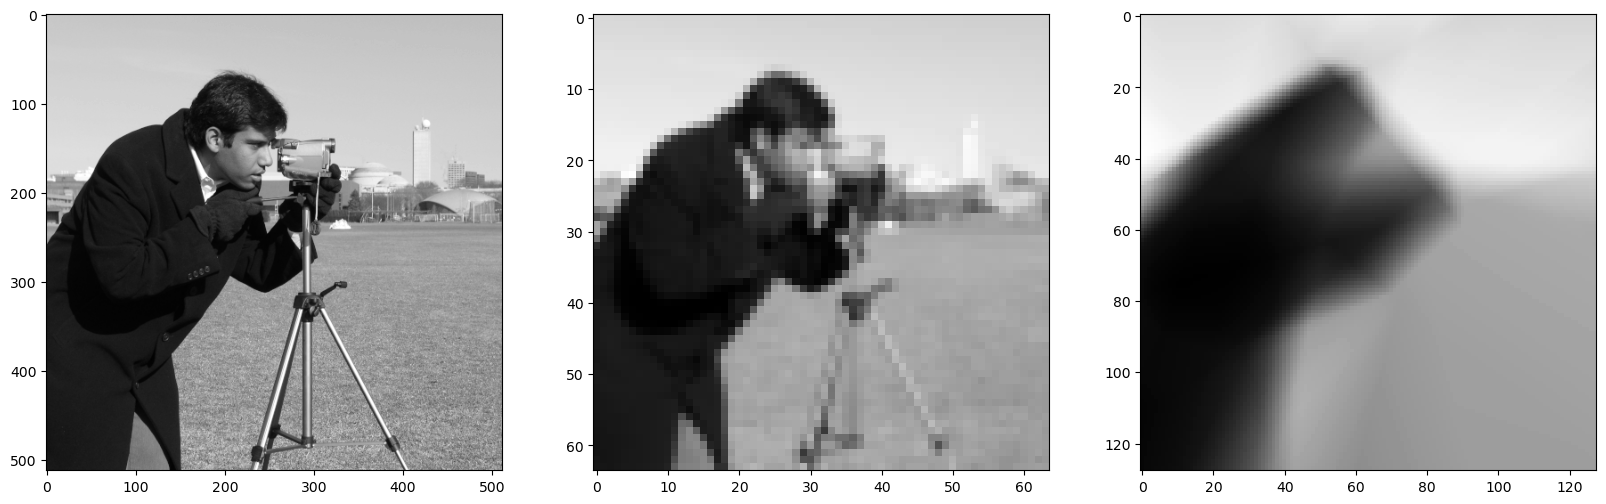

In [18]:
bigger_X = get_mgrid(128)
bigger_prediction = model.predict(bigger_X)
view_output(bigger_prediction, image_shape=(128, 128))

We have basically repurposed our humble model into something which can perform super-resolution!

We can also extend our input coordinates outside the bounds of [-1, 1]. This is getting into unknown territory now as this really is outside our original dataset (the image). At this point we're really asking the model to "imagine" what would be outside the boundaries of the original image (it's always nice to anthropomorphise these things).

Just to prove a point, we can give the model _any two numbers_ and it will give us something.

In [19]:
# Giving the model any old coordinates

a = model.predict([[0, 0]])
b = model.predict([[-2, 2]])
c = model.predict([[12, 99]])

print(a, b, c)

1/1 [==============================] - 0s 22ms/step
[[0.12787603]] [[0.05946013]] [[0.05457202]]


2023-01-25 20:30:51.265418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


To make new arbitrary input coordinates I'm going to re-write a version of `get_mgrid`. I could/should have just written the original function like this, but I wanted to keep it simple earlier.

> NB. The asterix (\*) in the function below spreads the array/tuple into its individual components. Much like '...' in JavaScript. So:
>
> `arr = [1,2,3]`
>
> `func(*arr) === func(1, 2, 3)`

In [21]:
def get_arbitrary_mgrid(sidelen, limits=(-1, 1)):
    '''Generates an arbitrary flattened grid of (x,y,...) coordinates of specified limits.'''
    width = np.linspace(*limits, sidelen)
    height = np.linspace(*limits, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)
    mgrid = np.reshape(mgrid, [-1, 2])
    return mgrid

512/512 [==============================] - 1s 2ms/step


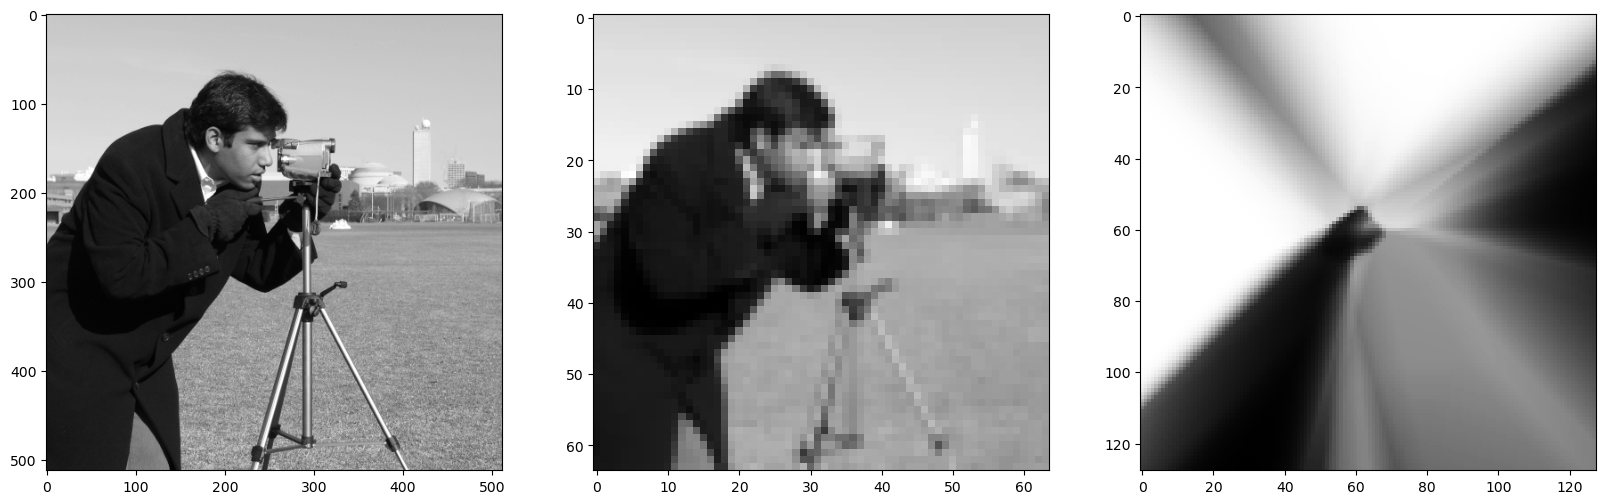

In [22]:
arbitrary_X = get_arbitrary_mgrid(128, limits=(-5, 5))
arbitrary_prediction = model.predict(arbitrary_X)
view_output(arbitrary_prediction, image_shape=(128, 128))

Or we could zoom in on a particular part of the image??

512/512 [==============================] - 1s 2ms/step


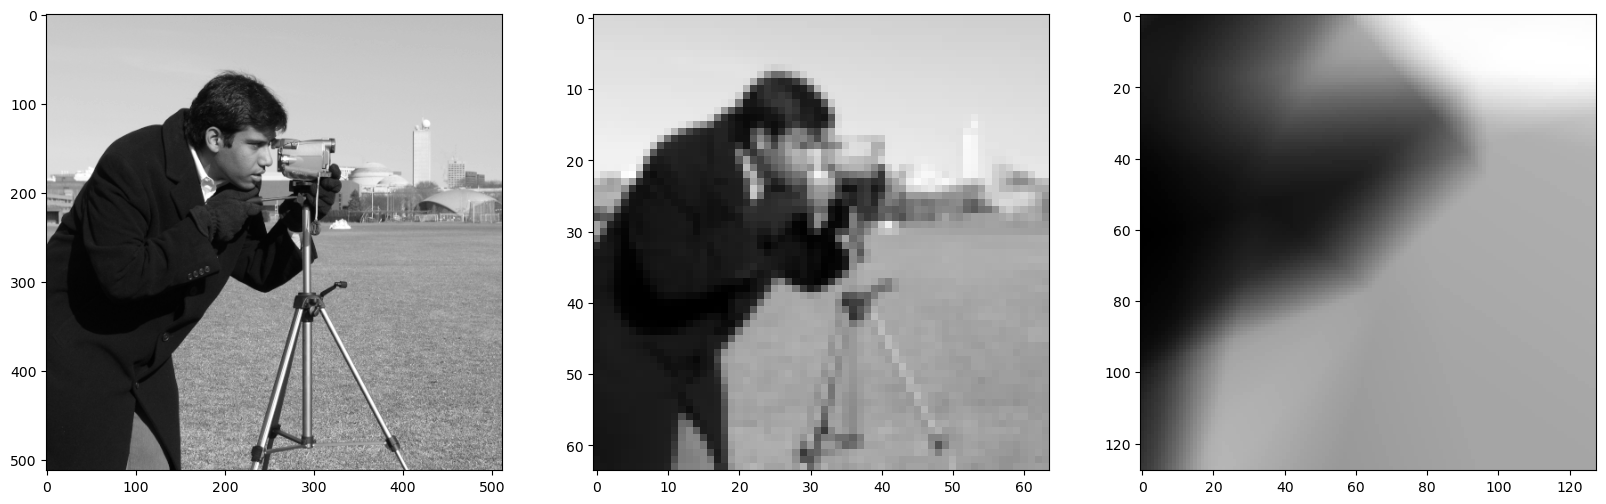

In [23]:
arbitrary_X = get_arbitrary_mgrid(128, limits=(-0.5, 0.7))
arbitrary_prediction = model.predict(arbitrary_X)
view_output(arbitrary_prediction, image_shape=(128, 128))